#### The Viterbi Algorithm
Ayush Jamdar EE20B018

In Question 3, I write the Viterbi Algorithm to study the performance of an MLSE approach.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 2d is the minimum distance in 4-PAM
# 1/root 5 is for unit average symbol energy
e_bit = 1
d = 1/np.sqrt(5) 
N_sym = 100002
channel_f = [0.8, -1, 0.6] / np.sqrt(2)

I_k = np.random.choice([-3*d, -d, d, 3*d], size=N_sym-2)
I_k = np.append(I_k, np.array((3*d, 3*d))) # these will be used for decoding
snr_range = np.arange(0, 18, 2)
# sigma_range = np.sqrt(e_bit*(10**(-snr_range/10)))
sigma_range = e_bit*(10**(-snr_range/10))

In [4]:
def get_r(I_k, V_k, channel_f):
    '''
    A 3-tap channel is described here

    input: symbol sequence, noise to be added and channel coefficients
    output: r_k received (modelled) sequence
    '''
    I_k_padded = np.concatenate((np.zeros(len(channel_f)-1), I_k))
    r_k = np.zeros(len(I_k))
    
    for i in range(len(I_k)):
        r_k[i] = (
                  I_k_padded[(i+2)]*channel_f[0]   +
                  I_k_padded[(i+2)-1]*channel_f[1] + 
                  I_k_padded[(i+2)-2]*channel_f[2]
        )

    r_k += V_k  
    return r_k

# get_r(np.array([1, 1, 1, 2]), np.array([0, 0, 0, 0]), channel_f)

In [5]:
def get_best_symbol_node_indices(transition_metric):
    ''' 
    This function is designed for a 4-PAM modulation scheme and a 3-tap channel.
    It determines the best previous node indices for each current node in the trellis diagram.
    
    Parameters:
    transition_metric (numpy.ndarray): The transition metric values for the trellis diagram.

    Returns:
    best_symbol_indices (numpy.ndarray): A 16x1 array where each element signifies the best previous node index for that node.
    '''
    
    best_symbol_indices = []
    
    # Iterate over each possible symbol (0, 1, 2, 3) in 4-PAM
    for i in [0, 1, 2, 3]:
        # Gather the transition metrics for all paths leading to nodes associated with symbol 'i'
        paths_at_nodes = np.array((transition_metric[i], transition_metric[i+4], transition_metric[i+8], transition_metric[i+12]))
        
        # Determine the indices of the paths with the smallest metric (best paths)
        # Reshape to a 4x1 matrix and map these indices to correspond to a 16x1 matrix
        best_path_to_nodes = (np.argmin(paths_at_nodes, axis=0).reshape((4, 1))) * 4 + i  
        
        best_symbol_indices.append(best_path_to_nodes)
    
    # Reshape the list of best path indices to a 16x1 numpy array
    best_symbol_indices = np.array(best_symbol_indices).reshape((16, 1))
    
    return best_symbol_indices


In [6]:
def viterbi(r_k, d, channel_f, sigma, delta, N_sym):
    ''' 
    Here the MLSE is performed
    input: d is half of d_min, r_k is the received sequence
    output: the survivor sequence of length N_sym
    delta must be > 2
    '''

    # generate the r_hat matrix
    # this matrix (16*4) contains the f.I for sequences
    symbols = np.array([-3*d, -d, d, 3*d])
    nodes = np.array([[(i, s) for i in symbols] for s in symbols]).reshape(16, 2)
    r_hat = np.array([
                      [(channel_f[0]*s + channel_f[1]*node[0] + channel_f[2]*node[1]) for s in symbols] 
                      for node in nodes
                    ])
    
    # (r_i.shape) = 16, 4

    # Now, start the algorithm
    # we need to maintain a survivor seq and cumulative metric
    cumulative_metric = np.zeros((16, 1)) # 16x1
    
    # compute the transition metric when only one symbol is received
    r_hat_0 = symbols*channel_f[0]
    trans_metric_0 = (r_hat_0 - r_k[0]) ** 2

    # this metric will initialize the cumulative matrix that works further
    cumulative_metric[0:4] += trans_metric_0[0]
    cumulative_metric[4:8] += trans_metric_0[1]
    cumulative_metric[8:12] += trans_metric_0[2]
    cumulative_metric[12:16] += trans_metric_0[3]

    # next stage, r(1) is received
    r_hat_1 = np.array(([-3*d, -d, d, 3*d] * 4))*channel_f[0] + np.array(([-3*d]*4 + [-d]*4 + [d]*4 + [3*d]*4))*channel_f[1] 
    trans_metric_1 = ((r_hat_1 - r_k[1]) ** 2).reshape((16, 1))
    cumulative_metric += trans_metric_1

    # now initialize the survivor seqs matrix0
    survivor_seqs = np.array([[0]*4 + [1]*4 + [2]*4 + [3]*4]).reshape(16, 1)
    survivor_seqs = np.hstack((survivor_seqs, np.array([0, 1, 2, 3] * 4).reshape(16, 1)))

    # print("Cumulative metric: \n", cumulative_metric)
    # print("survivor seq: \n", survivor_seqs)
    
    mlse_seq = np.zeros((N_sym, 1))

    for i in range(2, N_sym):
        if i % 10000 == 0:
            print("Iter: ", i)

        # print("Iteration: ", i)
        transition_metric = (r_hat - r_k[i]) ** 2
        tm_plus_cm = transition_metric + cumulative_metric # 16x4
        # print("TM + CM: \n", tm_plus_cm)
        # print("TM: \n", transition_metric)
        best_symbol_node_indices = get_best_symbol_node_indices(tm_plus_cm) # this should be 16x1
        # print("Best symbol node indices: \n", best_symbol_node_indices)
        
        # now we need to select the best sequence
        survivor_seqs_new = []
        cumulative_metric_new = np.zeros((16, 1))
        
        # now add the best transition metric to the cumulative metric
        for j in range(16):
            new_seq = np.append(survivor_seqs[best_symbol_node_indices[j][0], :], j % 4)
            survivor_seqs_new.append(new_seq)
            cumulative_metric_new[j] = (
                                    (cumulative_metric + transition_metric)[best_symbol_node_indices[j], j % 4]
                                )
        
        cumulative_metric = cumulative_metric_new
        
        survivor_seqs = np.array(survivor_seqs_new)

        if i >= delta:
            mlse_seq[i-delta] = survivor_seqs[np.argmin(cumulative_metric), 0]
            survivor_seqs = survivor_seqs[:, 1:]

        if i == N_sym-1:
            mlse_seq[i-delta+1:] = survivor_seqs[-1, :].reshape((delta, 1))
            # here we use the information that the last two symbols are 3d and 3d


        # now decode the sequence by mapping the survivor seq to the symbols
        mlse_seq[mlse_seq == 0] = -3*d
        mlse_seq[mlse_seq == 1] = -d
        mlse_seq[mlse_seq == 2] = d
        mlse_seq[mlse_seq == 3] = 3*d

    return mlse_seq.reshape((N_sym, ))

In [7]:
deltas = [3, 6, 10, 20, 40]
SER = {delta: [] for delta in deltas}

for delta in deltas:
    for sigma in sigma_range:
        print("Delta = ", delta, "| Sigma = ", sigma)
        noise = np.random.normal(0, sigma, size=N_sym)
        r_k = get_r(I_k, noise, channel_f)
        mlse_sequence = viterbi(r_k, d, channel_f, sigma, delta, N_sym)
        error_indices = np.where(mlse_sequence[:-2] != I_k[:-2])[0]
        error_count = len(error_indices)
        error_rate = error_count / (N_sym-2)
        SER[delta].append(error_rate)
        print("Error Rate = ", error_rate)

Delta =  3 | Sigma =  1.0
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.5783
Delta =  3 | Sigma =  0.6309573444801932
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.52637
Delta =  3 | Sigma =  0.3981071705534972
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.45485
Delta =  3 | Sigma =  0.251188643150958
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.35236
Delta =  3 | Sigma =  0.15848931924611134
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.13986
Delta =  3 | Sigma =  0.1
Iter:  10000
Iter:  

C:\Users\USER\AppData\Local\Temp\ipykernel_3892\1111751459.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(snr_range, np.log10(SER[delta]), label="delta = "+str(delta))


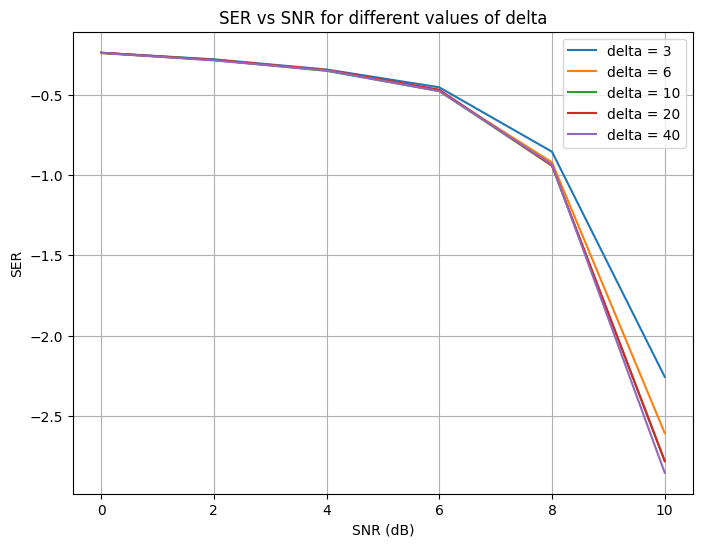

In [8]:
# plot SER
plt.figure(figsize=(8, 6))
for delta in deltas:
    plt.plot(snr_range, np.log10(SER[delta]), label="delta = "+str(delta))
plt.legend()
plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("SER")
plt.title("SER vs SNR for different values of delta")
plt.savefig("SER_vs_SNR_MLSE.png")
plt.show()

Here I experiment by using a large `delta`. It is observed that error rate reduces further on using large deltas.

In [9]:
noise = np.random.normal(0, sigma_range[-1], size=N_sym)
r_k = get_r(I_k, noise, channel_f)
mlse_sequence = viterbi(r_k, d, channel_f, sigma, N_sym//2, N_sym)
error_indices = np.where(mlse_sequence[:-2] != I_k[:-2])[0]
error_count = len(error_indices)
error_rate = error_count / (N_sym-2)
print("Error Rate = ", error_rate)

Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.0
